In [1]:
%%capture
!pip3 install daam
!pip install diffusers
!pip3 install ftfy
!pip3 install transformers
!pip3 install accelerate

In [2]:
import os
import shutil
import json
import torch
from diffusers import StableDiffusionPipeline
from typing import Any, Optional, Tuple, Union
import numpy as np
import torch
import random
import torch.nn.functional as F
from tqdm import tqdm
import math
import random
from transformers import CLIPTextModel, CLIPTokenizer
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import daam

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
model_id = "runwayml/stable-diffusion-v1-5"
device = "cuda"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker = None)
pipe = pipe.to(device)
pipe.enable_attention_slicing()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [4]:
def set_seed(seed):
  gen = torch.Generator(device=device)
  random.seed(seed)
  np.random.seed(seed)
  torch.cuda.manual_seed(seed)
  torch.manual_seed(seed)

  return gen.manual_seed(seed)

In [5]:
def show_each_step(images):
  num_images = len(images)
  num_cols = 8
  num_rows = num_images // num_cols + (num_images % num_cols > 0)  # Calculate number of rows needed

  fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 2))

  for i, image in enumerate(images):
      row = i // num_cols
      col = i % num_cols
      ax = axes[row, col] if num_rows > 1 else axes[col]
      ax.imshow(image)
      ax.axis('off')

  # Hide empty subplots
  for i in range(num_images, num_rows * num_cols):
      row = i // num_cols
      col = i % num_cols
      axes[row, col].axis('off')

  plt.tight_layout()
  plt.show()

In [6]:
global image_list

def callback(iter, t, latents):
    # convert latents to image
    with torch.no_grad():
        latents = 1 / 0.18215 * latents
        image = pipe.vae.decode(latents).sample

        image = (image / 2 + 0.5).clamp(0, 1)

        # we always cast to float32 as this does not cause significant overhead and is compatible with bfloa16
        image = image.cpu().permute(0, 2, 3, 1).float().numpy()

        # convert to PIL Images
        image = pipe.numpy_to_pil(image)

        # do something with the Images
        for i, img in enumerate(image):
            #img.save(f"iter_{iter}_img{i}.png")
            image_list.append(img)

In [7]:
%%capture
!pip3 install emoji

In [8]:
import emoji

  0%|          | 0/50 [00:00<?, ?it/s]

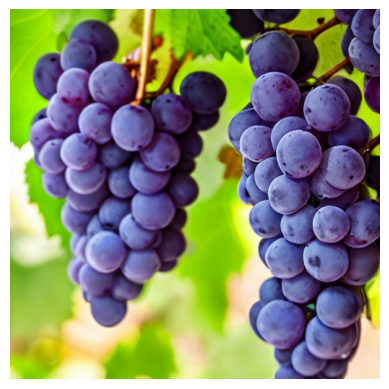

In [83]:
# generate image (note the `callback` and `callback_steps` argument)
seed = 457
prompt = "a purple grape cluster on a vine."

gen = set_seed(seed)  # for reproducibility
image_list = []
image = pipe(prompt, num_inference_steps=50, callback=callback, callback_steps=1,  generator=gen)
plt.imshow(image.images[0])
plt.axis('off')
plt.savefig("1.png", bbox_inches='tight')
plt.show()  # display it
# show_each_step(image_list)

a purple grape cluster on a vine. ☺️ canary ricciresponds europe dressing 🔶 handedly scene devastating


  0%|          | 0/50 [00:00<?, ?it/s]

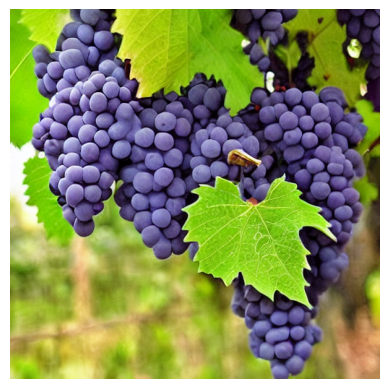

In [96]:
# generate image (note the `callback` and `callback_steps` argument)

prompt = emoji.emojize("a purple grape cluster on a vine. :smiling_face: canary ricciresponds europe dressing :large_orange_diamond: handedly scene devastating")
print(prompt)

seed=seed
gen = set_seed(seed)  # for reproducibility
#image_list = []
image = pipe(prompt, num_inference_steps=50, generator=gen)

plt.imshow(image.images[0])
plt.axis('off')
# plt.savefig("2.png", bbox_inches='tight')
plt.show()  # display it

# show_each_step(image_list)

a purple grape cluster on a vine. ☺️ canary ricciresponds europe dressing 🔶 handedly scene devastating
770


  0%|          | 0/50 [00:00<?, ?it/s]

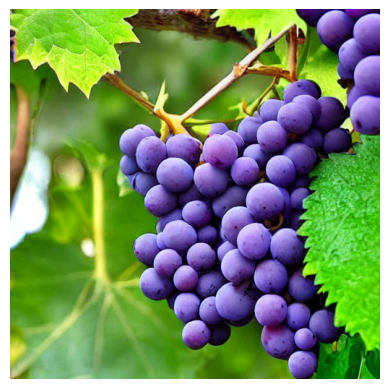

391


  0%|          | 0/50 [00:00<?, ?it/s]

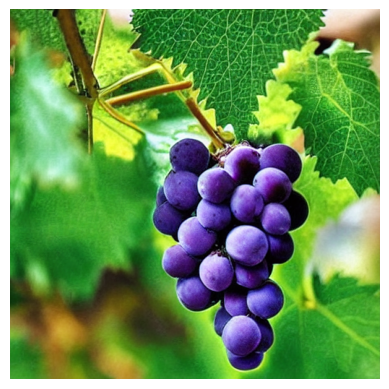

505


  0%|          | 0/50 [00:00<?, ?it/s]

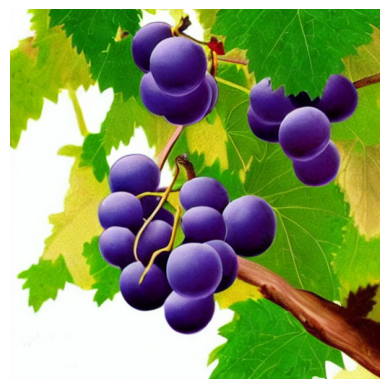

154


  0%|          | 0/50 [00:00<?, ?it/s]

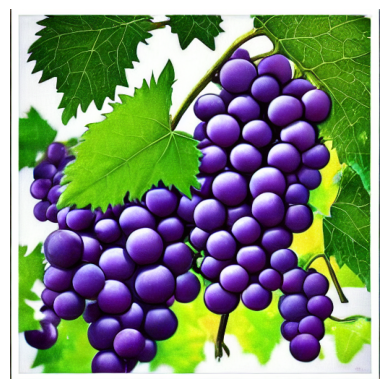

209


  0%|          | 0/50 [00:00<?, ?it/s]

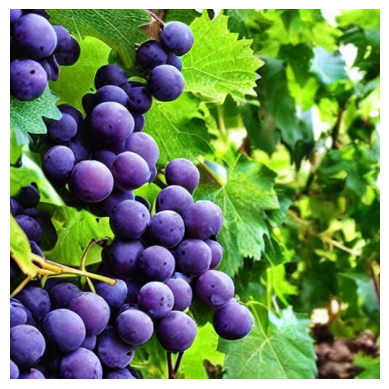

571


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# generate image (note the `callback` and `callback_steps` argument)

prompt = emoji.emojize("a purple grape cluster on a vine. :smiling_face: canary ricciresponds europe dressing :large_orange_diamond: handedly scene devastating")
print(prompt)

for i in range(10):
  seed = random.randint(1, 1000)
  print(seed)
  gen = set_seed(seed)  # for reproducibility
  #image_list = []
  image = pipe(prompt, num_inference_steps=50, generator=gen)

  plt.imshow(image.images[0])
  plt.axis('off')
  # plt.savefig("2.png", bbox_inches='tight')
  plt.show()  # display it

# show_each_step(image_list)

  0%|          | 0/50 [00:00<?, ?it/s]

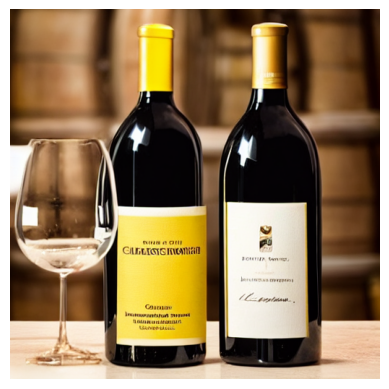

In [90]:
# generate image (note the `callback` and `callback_steps` argument)
seed = seed
prompt = emoji.emojize("-' goldengelian moschcited :yellow_heart::blue_heart: chardonnay highlights cellar simply")

gen = set_seed(seed)  # for reproducibility
image_list = []
image = pipe(prompt, num_inference_steps=50, callback=callback, callback_steps=1,  generator=gen)

plt.imshow(image.images[0])
plt.axis('off')
plt.savefig("3.png", bbox_inches='tight')
plt.show()  # display it

#show_each_step(image_list)

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-86-5b3c163c8685>:16: UserWarning: Glyph 128155 (\N{YELLOW HEART}) missing from current font.
  plt.tight_layout()
<ipython-input-86-5b3c163c8685>:16: UserWarning: Glyph 128153 (\N{BLUE HEART}) missing from current font.
  plt.tight_layout()
<ipython-input-86-5b3c163c8685>:17: UserWarning: Glyph 128155 (\N{YELLOW HEART}) missing from current font.
  plt.savefig("4.png", bbox_inches='tight')
<ipython-input-86-5b3c163c8685>:17: UserWarning: Glyph 128153 (\N{BLUE HEART}) missing from current font.
  plt.savefig("4.png", bbox_inches='tight')
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128155 (\N{YELLOW HEART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128153 (\N{BLUE HEART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


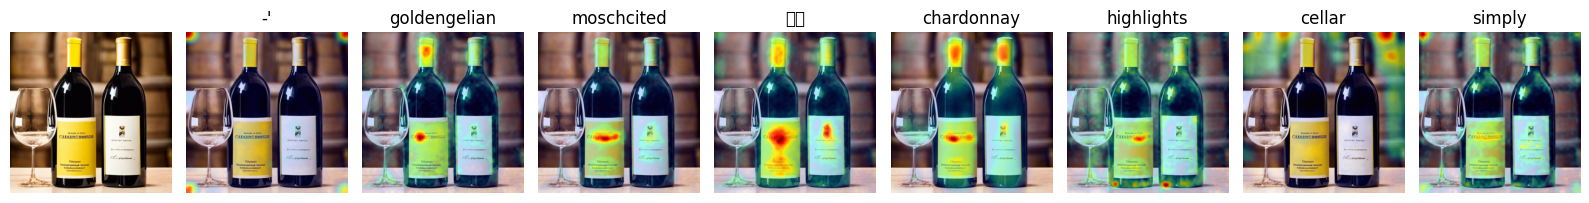

In [86]:
def view_image(heatmaps, original_img):
  num_imgs = len(heatmaps)+1
  fig, axes = fig, axes = plt.subplots(1, num_imgs, figsize=(16, 4 * 2))
  axes[0].imshow(original_img)
  axes[0].axis('off')

  cnt = 1
  for i in range(num_imgs):
    if i == 0:
      continue
    else:
      heatmaps[cnt-1].plot_overlay(original_img, ax=axes[i])
      cnt = cnt + 1
      axes[i].axis('off')

  plt.tight_layout()
  plt.savefig("4.png", bbox_inches='tight')
  plt.show()


seed = seed
prompt = emoji.emojize("-' goldengelian moschcited :yellow_heart::blue_heart: chardonnay highlights cellar simply")

gen = set_seed(seed)

with torch.no_grad():
  with daam.trace(pipe) as tc:
      out = pipe(prompt, num_inference_steps=50, generator=gen).images[0]
      heat_map = tc.compute_global_heat_map()
  wordlist = prompt.split()
  maplist = []
  for word in wordlist:
    map = heat_map.compute_word_heat_map(word)
    maplist.append(map)
  view_image(maplist, out)

In [ ]:
from diffusers.utils import load_image
img_url = "/content/1.png"
im1 = load_image(img_url)

img_url = "/content/2.png"
im2 = load_image(img_url)

In [ ]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    height, width = 512, 512
    image= pipe.image_processor.preprocess(input_im).to(torch.float16).to(pipe.device)
    with torch.no_grad():
      image = pipe.vae.encode(image).latent_dist.sample() * pipe.vae.config.scaling_factor
    return image

def latent_to_pil(latents):
    # convert latents to image
    with torch.no_grad():
        latents = 1 / 0.18215 * latents
        image = pipe.vae.decode(latents).sample

        image = (image / 2 + 0.5).clamp(0, 1)

        # we always cast to float32 as this does not cause significant overhead and is compatible with bfloa16
        image = image.cpu().permute(0, 2, 3, 1).float().numpy()

        # convert to PIL Images
        image = pipe.numpy_to_pil(image)

        plt.imshow(image[0])
        plt.axis('off')
        plt.show()  # display it

def latent2image(vae, latents):
    latents = 1 / 0.18215 * latents
    image = pipe.vae.decode(latents)['sample']
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    image = (image * 255).astype(np.uint8)
    return image

In [91]:
tokenizer = pipe.tokenizer
pipe.text_encoder = pipe.text_encoder.half()
model = pipe.text_encoder
tokenizer.pad_token = tokenizer.eos_token
MAX_LENGTH = tokenizer.model_max_length

In [92]:
text_a = "a photo of a purple grape cluster on a vine."
text_b = emoji.emojize("a photo of -' goldengelian moschcited :yellow_heart::blue_heart: chardonnay highlights cellar simply")

input_tokens = tokenizer(text_a, return_tensors="pt", padding="max_length",max_length=MAX_LENGTH, truncation=True)["input_ids"].to(device)
target_tokens = tokenizer(text_b, return_tensors="pt", padding="max_length",max_length=MAX_LENGTH, truncation=True)["input_ids"].to(device)

inp_toks = tokenizer(text_a).input_ids
print(inp_toks)
tar_toks = tokenizer(text_b).input_ids
print(tar_toks)

inp_len = len(inp_toks)
print(inp_len)
tar_len = len(tar_toks)

input_emb = None
target_emb = None
with torch.no_grad():
  input_emb = model(input_tokens)[0]
  target_emb = model(target_tokens)[0]

[49406, 320, 1125, 539, 320, 5496, 15959, 15595, 525, 320, 7721, 269, 49407]
[49406, 320, 1125, 539, 28010, 20650, 42508, 47003, 25069, 36337, 28161, 6173, 24282, 6151, 49407]
13


In [93]:
input_emb = input_emb.half()
target_emb = target_emb.half()

A = input_emb[:, 0:inp_len-1, :]
B = target_emb[:, 1:-inp_len+2, :]
lat = torch.cat((A, B), dim=1)

  0%|          | 0/50 [00:00<?, ?it/s]

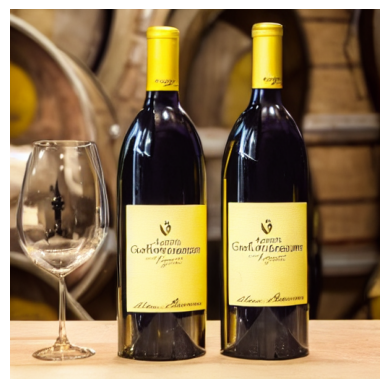

In [95]:
seed = 457
gen = set_seed(seed)  # for reproducibility

image_list = []
image = pipe(prompt_embeds = lat, num_inference_steps=50, callback=callback, callback_steps=1, generator=gen)

plt.imshow(image.images[0])
plt.axis('off')
plt.savefig("5.png", bbox_inches='tight')
plt.show()  # display it

# show_each_step(image_list)

  0%|          | 0/50 [00:00<?, ?it/s]

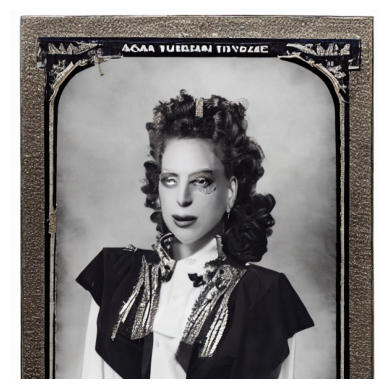

In [26]:
# generate image (note the `callback` and `callback_steps` argument)
seed = 495
prompt = "a photo of sements gaga tiazzle"

gen = set_seed(seed)  # for reproducibility
image = pipe(prompt, num_inference_steps=50, generator=gen)

plt.imshow(image.images[0])
plt.axis('off')
plt.savefig("6.png", bbox_inches='tight')
plt.show()  # display it

# Similarity Calculation

In [22]:
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-06)

In [23]:
def get_word_embed(wrd):
  input_id = tokenizer(wrd, return_tensors="pt", padding="max_length",max_length=MAX_LENGTH, truncation=True)["input_ids"].to(device)
  emb = model(input_id)[0]
  return emb[0].view(-1)

def token_and_embed(txt):
  txt_tokens = tokenizer(txt, return_tensors="pt", padding="max_length",max_length=MAX_LENGTH, truncation=True)["input_ids"].to(device)
  with torch.no_grad():
    txt_emb = model(txt_tokens)[0]
  return txt_emb[0].view(-1)

def measure_similarity(txtA, txtB, embA, embB):
  print("Cosine Similarity between (", txtA, ") and (", txtB, ") = ", cos(embA, embB).item())

In [24]:
input = "a white swan on a lake."
target = "a black swan on a lake."
adversary = "a white swan on a lake. black sements gaga tiazzle shares zalbraving scratches water"

adv_part1 = "a photo of a white swan on a lake."
adv_part2 = "a photo of black sements gaga tiazzle shares zalbraving scratches water"

suffix = "black sements gaga tiazzle shares zalbraving scratches water"
target_word = "black"
input_word = "white"

embed_input = token_and_embed(input)
embed_target = token_and_embed(target)
embed_adversary = token_and_embed(adversary)

embed_part1 = token_and_embed(adv_part1)
embed_part2 = token_and_embed(adv_part2)

embed_suffix = token_and_embed(suffix)
embed_tar_word = get_word_embed(target_word)
embed_in_word = get_word_embed(input_word)


checkO = "dog"
checkA = "lady"

checkB = "gaga"
checkC = "sements"
checkD = "tiazzle"
checkE = "sements gaga tiazzle"

noun = "swan"

embed_checkO = get_word_embed(checkO)
embed_checkA = get_word_embed(checkA)
embed_checkB = get_word_embed(checkB)
embed_checkC = get_word_embed(checkC)
embed_checkD = get_word_embed(checkD)
embed_checkE = get_word_embed(checkE)
embed_noun   = get_word_embed(noun)

In [25]:
measure_similarity(input, target, embed_input, embed_target)
measure_similarity(input, adversary, embed_input, embed_adversary)
measure_similarity(target, adversary, embed_target, embed_adversary)
measure_similarity(target, suffix, embed_target, embed_suffix)
measure_similarity(target_word, suffix, embed_tar_word, embed_suffix)
measure_similarity(input_word, suffix, embed_in_word, embed_suffix)
measure_similarity(target, adv_part2, embed_target, embed_part2)
print("")

measure_similarity(checkA, checkB, embed_checkA, embed_checkB)
measure_similarity(checkA, checkC, embed_checkA, embed_checkC)
measure_similarity(checkA, checkD, embed_checkA, embed_checkD)
measure_similarity(checkA, checkE, embed_checkA, embed_checkE)
print("")

measure_similarity(checkO, checkB, embed_checkO, embed_checkB)
measure_similarity(checkO, checkC, embed_checkO, embed_checkC)
measure_similarity(checkO, checkD, embed_checkO, embed_checkD)
measure_similarity(checkO, checkE, embed_checkO, embed_checkE)
print("")

measure_similarity(checkA, suffix, embed_checkA, embed_suffix)
measure_similarity(checkO, suffix, embed_checkO, embed_suffix)
print("")

measure_similarity(noun, checkB, embed_checkB, embed_noun)
measure_similarity(noun, checkA, embed_checkA, embed_noun)
measure_similarity(noun, checkO, embed_checkO, embed_noun)
measure_similarity(noun, checkE, embed_noun, embed_checkE)
measure_similarity(noun, suffix, embed_noun, embed_suffix)

Cosine Similarity between ( a white swan on a lake. ) and ( a black swan on a lake. ) =  0.79833984375
Cosine Similarity between ( a white swan on a lake. ) and ( a white swan on a lake. black sements gaga tiazzle shares zalbraving scratches water ) =  0.39501953125
Cosine Similarity between ( a black swan on a lake. ) and ( a white swan on a lake. black sements gaga tiazzle shares zalbraving scratches water ) =  0.55859375
Cosine Similarity between ( a black swan on a lake. ) and ( black sements gaga tiazzle shares zalbraving scratches water ) =  0.395751953125
Cosine Similarity between ( black ) and ( black sements gaga tiazzle shares zalbraving scratches water ) =  0.28955078125
Cosine Similarity between ( white ) and ( black sements gaga tiazzle shares zalbraving scratches water ) =  0.09393310546875
Cosine Similarity between ( a black swan on a lake. ) and ( a photo of black sements gaga tiazzle shares zalbraving scratches water ) =  0.406982421875

Cosine Similarity between ( lad